In [1]:
import os
import sys
import argparse
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm

import scipy.misc
import random

import PIL.Image as Image
import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
import operator

import torch
import torch.nn.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.backends.cudnn as cudnn

from pytvision.transforms.aumentation import  ObjectImageMetadataTransform
from pytvision.transforms import transforms as mtrans

sys.path.append('../')
from torchlib.transforms import functional as F
from torchlib.datasets.factory  import FactoryDataset
from torchlib.datasets.datasets import Dataset
from torchlib.datasets.fersynthetic  import SyntheticFaceDataset

from torchlib.attentionnet import AttentionNeuralNet, AttentionGMMNeuralNet
from aug import get_transforms_aug, get_transforms_det

import matplotlib.pyplot as plt
plt.ion()   # interactive mode


## CONFIGURATE

In [2]:
!ls ../out/attnet

att_attnet_ferattention_attloss_adam_affectnetdark_dim64_preactresnet18x32_fold0_000
att_attnet_ferattention_attloss_adam_bu3dfedark_dim64_preactresnet18x32_fold0_000
att_attnet_ferattention_attloss_adam_ckdark_dim64_preactresnet18x32_fold0_000
att_attnet_ferattention_attloss_adam_jaffedark_dim64_preactresnet18x32_fold0_000


In [229]:
project          = '../out/attnet'
name             = 'att_attnet_ferattention_attloss_adam_affectnetdark_dim64_preactresnet18x32_fold0_000'
pathnamedataset  = '~/.datasets'
pathmodel        = os.path.join( project, name, 'models/model_best.pth.tar' ) #model_best, chk000110
pathproject      = os.path.join( project, name )
batch_size       = 1
workers          = 1
cuda             = False
parallel         = False
gpu              = 1
seed             = 1
imsize           = 64

## LOAD MODEL

In [230]:
# load model
print('>> Load model ...')

net = AttentionNeuralNet( 
    patchproject=project, 
    nameproject=name, 
    no_cuda=cuda, 
    parallel=parallel, 
    seed=seed, 
    gpu=gpu 
    )

if net.load( pathmodel ) is not True:
    assert(False)

>> Load model ...
=> loading checkpoint '../out/attnet/att_attnet_ferattention_attloss_adam_affectnetdark_dim64_preactresnet18x32_fold0_000/models/model_best.pth.tar'
=> loaded checkpoint for ferattention arch!


## DATASETS

In [5]:
print('>> Load dataset ...')
namedataset = FactoryDataset.ferp
subset = FactoryDataset.validation
imagesize=128

dataset = Dataset(    
    data=FactoryDataset.factory(
        pathname=pathnamedataset, 
        name=namedataset, 
        subset=subset, 
        download=True 
    ),
    num_channels=3,
    transform=transforms.Compose([
            mtrans.ToResize( (imagesize,imagesize), resize_mode='square' ),
            mtrans.ToTensor(),
            #mtrans.ToMeanNormalization( mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] )
            mtrans.ToNormalization(),
            ])
    )

# emotions = dataset.data.classes
emotions = ['Neutral - NE', 'Happiness - HA', 'Surprise - SU', 'Sadness - SA', 'Anger - AN', 'Disgust - DI', 'Fear - FR', 'Contempt - CO']

# if namedataset == FactoryDataset.bu3dfe:
#     emotions = emotions[:-1]
print(emotions)
print(len(emotions))


>> Load dataset ...
['Neutral - NE', 'Happiness - HA', 'Surprise - SU', 'Sadness - SA', 'Anger - AN', 'Disgust - DI', 'Fear - FR', 'Contempt - CO']
8


(64, 64, 3)
tensor([0.1086, 0.1268, 0.1112, 0.1147, 0.1085, 0.1144, 0.1093, 0.2066],
       device='cuda:1')
tensor(7, device='cuda:1')
Contempt - CO


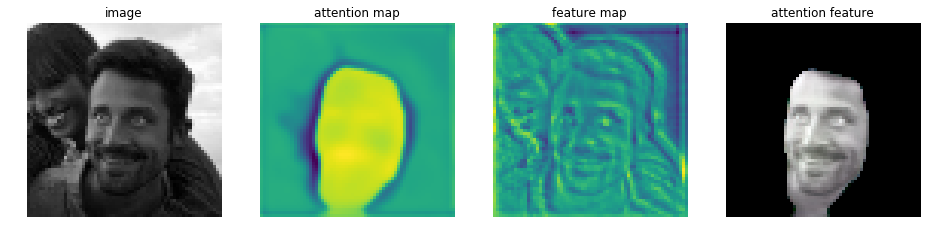

In [6]:


def sigmoid(x):
    return 1. / (1 + np.exp(-x))

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def norm(x):
    x = x-x.min()
    x = x / x.max()
    return x

def mean_normalization(image, mean, std):
    tensor = image.float()/255.0
    result_tensor = []
    for t, m, s in zip(tensor, mean, std):  
        result_tensor.append(t.sub_(m).div_(s))            
    return torch.stack(result_tensor, 0)

def pad(image, xypad):
    h,w = image.shape
    im_pad = np.zeros( (h+2*xypad,w+2*xypad) )
    im_pad[xypad:xypad+h,xypad:xypad+w] = image
    return im_pad
    
def crop(image, xycrop):
    h,w = image.shape[:2]
    image = image[ xycrop:h-xycrop,xycrop:w-xycrop ]
    return image 
    
imagesize=64
image = cv2.imread('../rec/selfie_happy_dos.png')[:,:,0]
# image = pad(image,50)
# image = crop(image,10)

# sigma=0.1
# image = image/255.0
# noise = np.array([random.gauss(0,sigma) for i in range( image.shape[0]*image.shape[1]  )])
# noise = noise.reshape(image.shape[0],image.shape[1])
# image = (np.clip(image+noise,0,1)*255).astype(np.uint8)

image = np.stack( (image,image,image), axis=2 )
image = cv2.resize( image, (imagesize, imagesize) )

# gamma=0.1
# image[:,:,0] = norm((image[:,:,0]/255)**gamma)*255
# image[:,:,1] = norm((image[:,:,1]/255)**gamma)*255
# image[:,:,2] = norm((image[:,:,2]/255)**gamma)*255

image = torch.from_numpy(image).permute( (2,0,1) ).unsqueeze(0).float()
# image = mean_normalization(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
image = image/255

y_lab_hat, att, fmap, srf = net( image )




att  = att.data.cpu().numpy().transpose(2,3,1,0)[...,0]
fmap = fmap.data.cpu().numpy().transpose(2,3,1,0)[...,0]
srf  = srf.data.cpu().numpy().transpose(2,3,1,0)[...,0]
image = image.data.cpu().numpy().transpose(2,3,1,0)[...,0]
y_lab_hat_max = y_lab_hat.argmax()
# print('att', att.shape, att.min(), att.max())


print(image.shape)
print( TF.softmax( y_lab_hat, dim=1 )[0,:]  )
print(y_lab_hat_max)
print(emotions[y_lab_hat_max])

plt.figure( figsize=(16,8))
plt.subplot(141)
plt.imshow( norm(image) )
plt.title('image')   
plt.axis('off')
plt.subplot(142)
plt.imshow( fmap.mean(2) )
plt.title('attention map') 
plt.axis('off' )
plt.subplot(143)
plt.imshow( srf.mean(2) )
plt.title('feature map') 
plt.axis('off' )
plt.subplot(144)
plt.imshow( norm(att) )  
# plt.title('class {}'.format( y_lab_hat_max ) ) 
plt.title('attention feature') 
plt.axis('off')



plt.show()

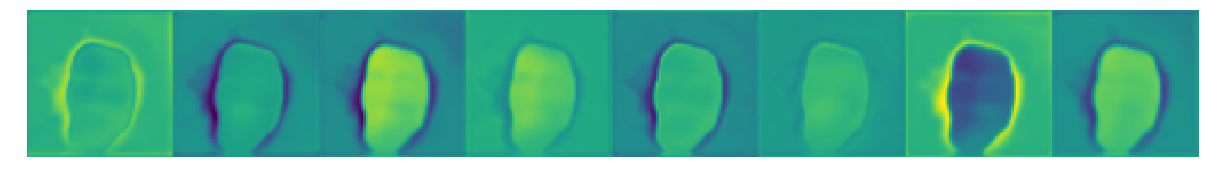

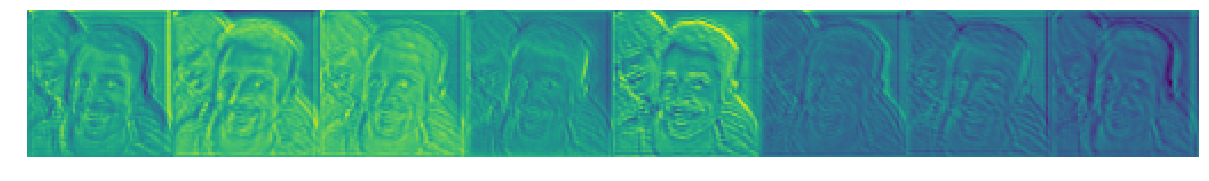

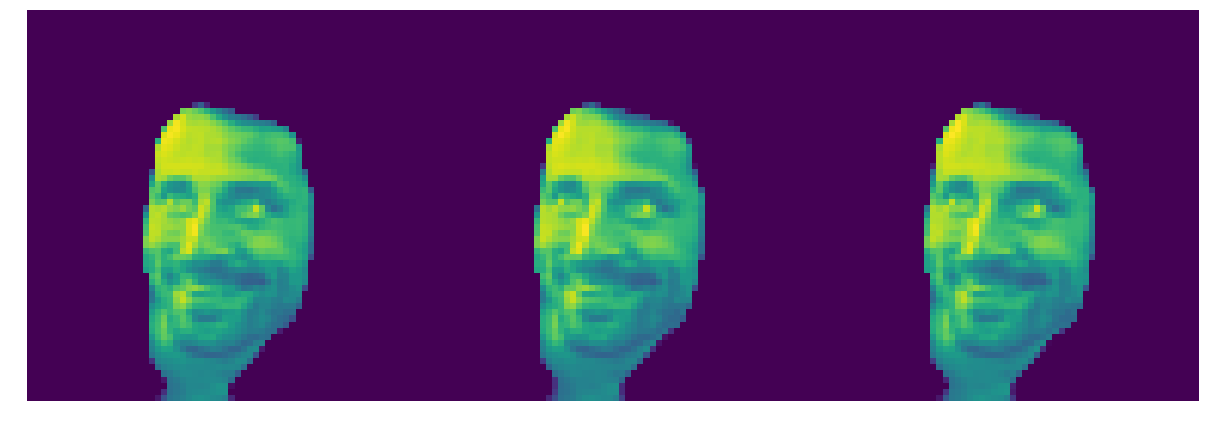

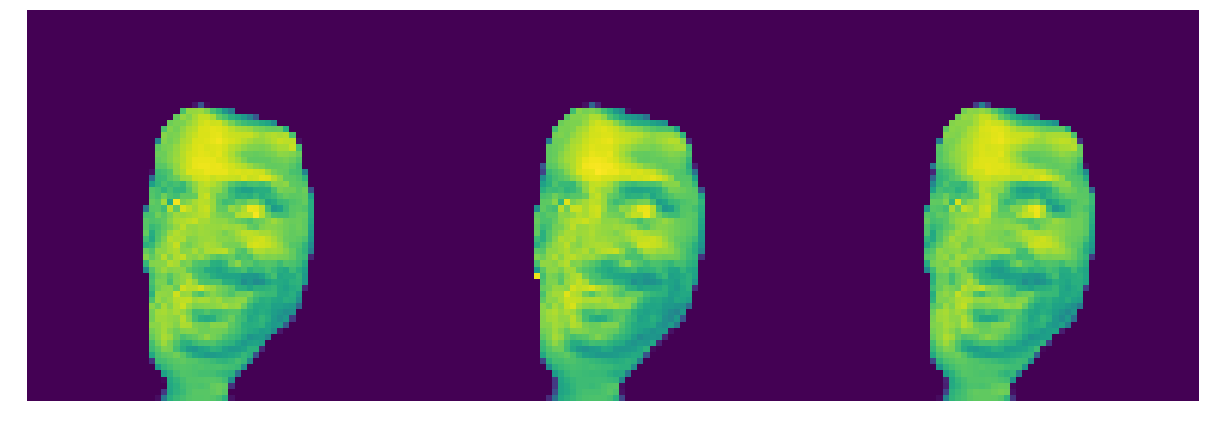

In [7]:
# att, fmap, srf 

def to_expand( x ):
    x_exp = [ ix  for ix in x.transpose( (2,0,1) )  ]
    x_exp = np.concatenate(x_exp, axis=1 )
    return x_exp

def imshow(im, figsize=(8,8) ):
    plt.figure( figsize=figsize )
    plt.imshow( im )
    plt.axis('off')
    plt.ioff()
    plt.show()

im_fmap = to_expand(fmap)
im_srf  = to_expand(srf)
im_att  = to_expand(att)

# im_err_c1  = att[:,:, 0] - image
# im_err_c2  = att[:,:, 1] - image
# im_err_c3  = att[:,:, 2] - image
# im_err = np.stack( (im_err_c1,im_err_c2,im_err_c3) , axis=1 )

im_err = (np.abs(att - image)) *(att>0 )
im_err  = to_expand(im_err)


imshow(im_fmap, figsize=(21,8)  )
imshow(im_srf, figsize=(21,8)  )
imshow( im_att, figsize=(21,8)  )
imshow( im_err, figsize=(21,8)  )



In [312]:

STANDARD_COLORS = [
    'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque',
    'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite',
    'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan',
    'DarkCyan', 'DarkGoldenRod', 'DarkGrey', 'DarkKhaki', 'DarkOrange',
    'DarkOrchid', 'DarkSalmon', 'DarkSeaGreen', 'DarkTurquoise', 'DarkViolet',
    'DeepPink', 'DeepSkyBlue', 'DodgerBlue', 'FireBrick', 'FloralWhite',
    'ForestGreen', 'Fuchsia', 'Gainsboro', 'GhostWhite', 'Gold', 'GoldenRod',
    'Salmon', 'Tan', 'HoneyDew', 'HotPink', 'IndianRed', 'Ivory', 'Khaki',
    'Lavender', 'LavenderBlush', 'LawnGreen', 'LemonChiffon', 'LightBlue',
    'LightCoral', 'LightCyan', 'LightGoldenRodYellow', 'LightGray', 'LightGrey',
    'LightGreen', 'LightPink', 'LightSalmon', 'LightSeaGreen', 'LightSkyBlue',
    'LightSlateGray', 'LightSlateGrey', 'LightSteelBlue', 'LightYellow', 'Lime',
    'LimeGreen', 'Linen', 'Magenta', 'MediumAquaMarine', 'MediumOrchid',
    'MediumPurple', 'MediumSeaGreen', 'MediumSlateBlue', 'MediumSpringGreen',
    'MediumTurquoise', 'MediumVioletRed', 'MintCream', 'MistyRose', 'Moccasin',
    'NavajoWhite', 'OldLace', 'Olive', 'OliveDrab', 'Orange', 'OrangeRed',
    'Orchid', 'PaleGoldenRod', 'PaleGreen', 'PaleTurquoise', 'PaleVioletRed',
    'PapayaWhip', 'PeachPuff', 'Peru', 'Pink', 'Plum', 'PowderBlue', 'Purple',
    'Red', 'RosyBrown', 'RoyalBlue', 'SaddleBrown', 'Green', 'SandyBrown',
    'SeaGreen', 'SeaShell', 'Sienna', 'Silver', 'SkyBlue', 'SlateBlue',
    'SlateGray', 'SlateGrey', 'Snow', 'SpringGreen', 'SteelBlue', 'GreenYellow',
    'Teal', 'Thistle', 'Tomato', 'Turquoise', 'Violet', 'Wheat', 'White',
    'WhiteSmoke', 'Yellow', 'YellowGreen'
]


def sigmoid(x):
    return 1. / (1 + np.exp(-x))

def imageshow( image ):
    plt.figure( figsize=(10,10))
    plt.imshow(image)
    plt.axis('off')
    plt.ioff()
    plt.show()


# x,y,w,h -> x1,y1,x2,y2 
def tobbox(box):
    return np.array( [box[0], box[1], box[2]+box[0], box[3]+box[1] ] )

def roi( image, box, pad=0 ):
    imgray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    h,w = imgray.shape
    
    # top bottom right left 
    top    = max( box[1]-pad, 0 )
    bottom = min( box[3]+pad, h )
    left   = max( box[0]-pad, 0 )
    right  = min( box[2]+pad, w )
    
    #roi_gray = imgray[box[1]:box[3], box[0]:box[2]]
    roi_gray = imgray[top:bottom, left:right ]
    return roi_gray,[left,top,right,bottom]

def dictbox2arraybox(box):
    bbox = np.array([box['top'],box['left'],box['top']+box['width'],box['left']+box['height']])
    return bbox

def norm(x):
    x = x-x.min()
    x = x / x.max()
    return x

def mean_normalization(image, mean, std):
    tensor = image.float()/255.0
    result_tensor = []
    for t, m, s in zip(tensor, mean, std):  
        result_tensor.append(t.sub_(m).div_(s))            
    return torch.stack(result_tensor, 0)

def pad(image, xypad):
    h,w = image.shape[:2]
    im_pad = np.zeros( (h+2*xypad,w+2*xypad,3), dtype=np.uint8 )
    im_pad[xypad:xypad+h,xypad:xypad+w, :] = image
    return im_pad

def crop(image, xycrop):
    h,w = image.shape[:2]
    image = image[ xycrop:h-xycrop,xycrop:w-xycrop , :]
    return image 

def fusion( imx, imy, x=0, y=0, alpha=0.5 ):
    n,m = imy.shape[:2]
    imx[ x:x+n,y:y+m, : ] = alpha*imx[ x:x+n,y:y+m, : ] + (1-alpha)*imy
    return imx

def noise(image, sigma=0.05):
    image = image/255.0
    noise = np.array([random.gauss(0,sigma) for i in range( image.shape[0]*image.shape[1]*3  )])
    noise = noise.reshape(image.shape[0],image.shape[1],3)
    image = (np.clip(image+noise,0,1)*255).astype(np.uint8)
    return image
    
def ligth(image, gamma=0.2):
    image[:,:,0] = norm((image[:,:,0]/255)**gamma)*255
    image[:,:,1] = norm((image[:,:,1]/255)**gamma)*255
    image[:,:,2] = norm((image[:,:,2]/255)**gamma)*255
    return image

class cTrack(object):
    '''track frame
    '''
    
    def __init__(self, net, image_size=64):
        self.imagesize=image_size
        self.net=net
    
    def __call__(self, frame):
        
        #image = frame
        image = frame.mean(axis=2)        
        image = np.stack( (image,image,image), axis=2 )
        
        image = cv2.resize( image, (self.imagesize, self.imagesize) )
        image = torch.from_numpy(image).permute( (2,0,1) ).unsqueeze(0).float()
        #image = mean_normalization(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        image = image/255
        
        y_lab_hat, att, fmap, srf = self.net( image )
        
        att = att.data.cpu().numpy().transpose(2,3,1,0)[...,0]
        fmap = fmap.data.cpu().numpy().transpose(2,3,1,0)[...,0]
        srf  = srf.data.cpu().numpy().transpose(2,3,1,0)[...,0]
        y_lab_hat_max = y_lab_hat.argmax()
        
        return att, fmap, srf, y_lab_hat, y_lab_hat_max

    
class cFrame(object):
    '''frames process
    '''        
    def __init__(self, image_size=[640, 640, 3], border=0, offsetx=0, offsety=0):     
        self.imagesize  = image_size
        self.asp = float(image_size[1])/image_size[0]
        self.border = border
        self.offsetx = offsetx
        self.offsety = offsety 
       
        
    def __call__(self, frame):
        '''process frame 
        '''        
        #H, W original image size
        H=frame.shape[0]; W=frame.shape[1];
        
        #image canonization
        if H>W: frame = frame.transpose(1,0,2)
        H=frame.shape[0]; W=frame.shape[1]     
        
        H1 = int(H - self.border)
        W1 = int(H1 * self.asp)
        offsetx=self.offsetx
        offsety=self.offsety
        Wdif = int(np.abs(W - W1) / 2.0)
        Hdif = int(np.abs(H - H1) / 2.0)
        vbox = np.array([[Wdif, Hdif], [W - Wdif, H - Hdif]])

        frame_p = frame[vbox[0, 1]+offsety:vbox[1, 1]+offsety, vbox[0, 0]+offsetx:vbox[1, 0]+offsetx, : ]; #(2, 1, 0)
        aspY = float(self.imagesize[0]) / frame_p.shape[0]
        aspX = float(self.imagesize[1]) / frame_p.shape[1]

        frame_p = scipy.misc.imresize(frame_p, (self.imagesize[0], self.imagesize[1]), interp='bilinear')
        
        return frame_p
    

class cFaceDetection(object):
    '''face detection process
    '''    
    def __init__(self,):
        self.face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    
    def __call__(self, image):
        imgray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        faces = self.face_cascade.detectMultiScale(imgray, 1.3, 5)
        return faces
        

    
def showatt( image, yhat, att, fmap, srf, emotions, imsize=500, midsize=250):
    
    #layer   = np.zeros( [768, 2024, 3] , dtype=np.float ) #1024    
    #caption = drawcaption(yhat, emotions )/255
    
    image   = cv2.resize( image/255, (imsize,imsize) )[:,:,(2,1,0)]
    #att     = cv2.resize( norm(att)*255, (imsize,imsize) )
    att     = cv2.resize( att, (imsize,imsize) )
    fmap    = cv2.resize( norm(fmap)*255, (imsize,imsize) )
    srf     = cv2.resize( norm(srf.sum(axis=2))*255, (imsize,imsize) )    
    
    #https://www.learnopencv.com/applycolormap-for-pseudocoloring-in-opencv-c-python/
    fmap = cv2.applyColorMap( fmap.astype(np.uint8) , cv2.COLORMAP_JET)[:,:,(2,1,0)]/255
    srf = cv2.applyColorMap( srf.astype(np.uint8), cv2.COLORMAP_JET)[:,:,(2,1,0)]/255    
    image   = np.concatenate( (image, fmap, srf, att), axis=1 )
    
    #layer = fusion(layer, image, x=10+100, y=10, alpha=0.0 )
    #layer = fusion(layer, caption, x=20+100, y=20, alpha=0.2 )
    
    return image

    
def draw_bounding_box(image, bbox, label, color='red', thickness=4):
    
    image_pil = Image.fromarray(np.uint8(image)).convert('RGB') 
    im_width, im_height = image_pil.size

    draw = ImageDraw.Draw(image_pil)
    #xmin = bbox[0,0]; ymin = bbox[0,1];
    #xmax = bbox[1,0]; ymax = bbox[1,1];
    #(left, right, top, bottom) = (xmin, xmax, ymin, ymax)
    (left, top, right, bottom ) = bbox

    draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
    
    try:
        font = ImageFont.truetype('/usr/share/fonts/freefont/FreeSans.ttf', 32, encoding="unic") #'arial.ttf'
        #font = ImageFont.truetype('arial.ttf', 32) 
    except IOError:
        font = ImageFont.load_default()
    
    text_bottom = top
    
    # Reverse list and print from bottom to top.
    #for display_str in display_str_list[::-1]:
    
    emtname=label[0]
    emtscore=label[1]
    display_str = '{}:{:.2f}% '.format( emtname, emtscore*100 );
    
    text_width, text_height = font.getsize( display_str )
    margin = np.ceil(0.05 * text_height)
    draw.rectangle(
        [(left, text_bottom - text_height - 2 * margin), 
        (left + text_width, text_bottom)],
        fill=color)
    
    draw.text(
        (left + margin, text_bottom - text_height - margin),
        display_str,
        fill='black',
        font=font)
    text_bottom -= text_height - 2 * margin
    
    np.copyto(image, np.array(image_pil))
    

    
def drawcaption( y, emotions, imsizeout=(200,200) ):    
    
    ne = len(emotions)
    colors = ([150,150,150],[125,125,125],[255,255,255],[255,255,255])
    hbox=40; wbox= 135 + 170
    
    imsize=(hbox*ne,wbox,3)
    imemotions = np.zeros( imsize, dtype=np.uint8 )*255    
    
    ymax = y.argmax()
    
    for i, yi in enumerate(y):

        k  = 1 if y[i]>0.5 else 0
        kh = 1 if ymax==i else 0
    
        bbox = np.array([[0,0],[wbox,0],[wbox,hbox],[0,hbox]]);    
        bbox[:,0] += 0
        bbox[:,1] += 26-26 + (i)*40
        imemotions = cv2.fillConvexPoly(imemotions, bbox, color=colors[kh] )
        
        bbox = np.array([[0,0],[int(wbox*y[i]),0],[int(y[i]*wbox),hbox],[0,hbox]]);    
        bbox[:,0] += 0
        bbox[:,1] += 26-26 + (i)*40
        imemotions = cv2.fillConvexPoly(imemotions, bbox, color=[255,160,122] )
        
        cv2.putText(
                imemotions, 
                #'{}: {:.3f}'.format(emotions[i][:-5],y[i]),
                '{}: {:.2f}%'.format(emotions[i][:-5], y[i]*100 ),
                (2, 26 + (i)*40), 
                color=colors[2+kh], 
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=1, 
                thickness=2
                )
        
    #imemotions = imemotions[20:-20,20:-20,:]
    imemotions = cv2.resize( imemotions, imsizeout )
    return imemotions


def drawface(image, bbox ):    
    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2],bbox[3]), color=[10,10,128], thickness=3)
    return image  



def create_vzframe(frame, face,  netout, emotions ):
    
    
    #create video frame   
    imsize=500
    midsize=250
    #layer   = np.zeros( [768, 2024, 3] , dtype=np.uint8 )*255 #1024   
    att, fmap, srf, yhat, yhat_max, score, labelhat, curremot = netout
    
    #caption = drawcaption(yhat, emotions )
    
    h,w = frame.shape[:2]
    W = imsize*4 + 20
    H = int(h* ( 1.0*W/w ) )
    frame = cv2.resize(frame, (W, H) )
    
    
    face    = cv2.resize( norm(face)*255, (imsize,imsize) )[:,:,(2,1,0)]
    att     = cv2.resize( norm(att)*255, (imsize,imsize) )
    fmap    = cv2.resize( norm(fmap.mean(axis=2))*255, (imsize,imsize) )
    srf     = cv2.resize( norm(srf.mean(axis=2))*255, (imsize,imsize) )
    
    #att    = cv2.resize( norm(att)*255, (midsize,midsize) )
    #fmap   = cv2.resize( norm(fmap)*255, (midsize,midsize) )
    #srf    = cv2.resize( norm(srf.sum(axis=2))*255, (midsize,midsize) )
    
    #https://www.learnopencv.com/applycolormap-for-pseudocoloring-in-opencv-c-python/
    fmap = cv2.applyColorMap( fmap.astype(np.uint8) , cv2.COLORMAP_JET)[:,:,(2,1,0)]
    srf = cv2.applyColorMap( srf.astype(np.uint8), cv2.COLORMAP_JET)[:,:,(2,1,0)]
    
    #att     = np.concatenate( (att, att_t), axis=0 )
    #feature = np.concatenate( (fmap, srf ), axis=0 )
    #feature = np.stack( (feature, feature,feature ), axis=2 )    
    #image   = np.concatenate( (image, feature, att), axis=1 )
    
    
    layer_net   = np.concatenate( (face.astype(np.uint8), fmap, srf, att.astype(np.uint8)), axis=1 )
    layer       = np.concatenate( (frame,  np.zeros( (200+50, frame.shape[1], 3), dtype=np.uint8 )  ), axis=0 )
    
    #layer
    dx = H+200-imsize-10
    dy = 10
    layer = fusion(layer, layer_net, x=dx, y=dy, alpha=0.2 )
    #layer = fusion(layer, caption, x=20+100, y=20, alpha=0.2 )
    
    cv2.putText( layer, 'Face Crop',  (50, dx + imsize  ), color=[255,255,255], fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, thickness=3 )
    cv2.putText( layer, 'Att',  (50 + 1*imsize, dx + imsize  ), color=[255,255,255], fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, thickness=3 )
    cv2.putText( layer, 'FT',  (50 + 2*imsize, dx + imsize  ), color=[255,255,255], fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, thickness=3 )
    cv2.putText( layer, 'Iatt',  (50 + 3*imsize, dx + imsize  ), color=[255,255,255], fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=2, thickness=3 )
    
    
    return layer
    



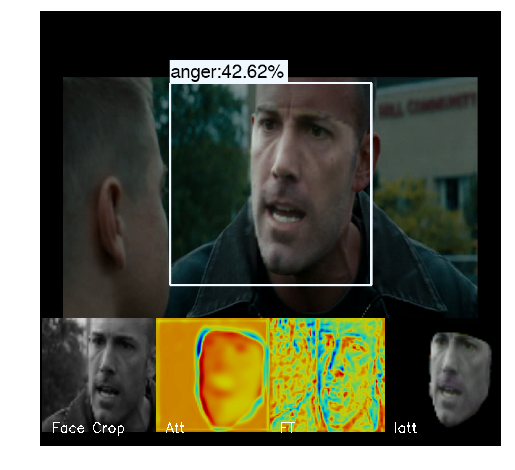

In [ ]:
import cv2 
from IPython.display import clear_output

emotion_name = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']

#1n, 2n, 4***, 5***, 8[], 12**, 
#4,5
filename = '../out/videos/0014/'

# cap = cv2.VideoCapture( filename )
# print(cap.isOpened())

det = cFaceDetection()
frame_proc = cFrame( image_size=[128,128,3] ) 
track   = cTrack( net, image_size=64 )

k = 0
iframe=0
totalframe=60
iniframe=20 #0, 1700

bligth=False
mingam, maxgam = 0.5, 3.0 
#gammas = mingam + np.random.rand(totalframe)*( maxgam - mingam )
#gammas = np.linspace( mingam, maxgam, num=totalframe+1 )
gammas = np.ones( (totalframe+1,1) ) * 4.0
gammas = gammas[::-1]
#gammas.sort()


bnoise=False
minnoise, maxnoise = 0.01, 0.08
# sigmas = minnoise + np.random.rand(totalframe)*( maxnoise - minnoise )
sigmas = np.linspace( minnoise, maxnoise, num=totalframe+1 )
sigmas = sigmas[::-1]
#sigmas.sort()


# for every frame
# while(cap.isOpened()):
while True:
    
    # read
    #for i in range(100): 
    #    ret, frame = cap.read()

    
#     ret, frame = cap.read()
#     if not ret:
#         k+=1
#         print('Error video')
#         break

        
    frame = cv2.imread( os.path.join(filename, 'im{:05d}.png'.format(iniframe+iframe+1) ) )     
           
    
    if k%1 != 0 or k < iniframe:
        k+=1
        continue
        
    
    frame = frame[:,:,(2,1,0)]
    frame = pad(frame, 40)    
    #frame = cv2.resize( frame, (0,0), fx=1.5, fy=1.5 )
    faces = det(frame)
    
    layer = frame.copy()
    if bligth: layer = np.clip(ligth(layer, gamma = gammas[iframe - iniframe] ), 0, 255 )  
    if bnoise: layer = np.clip(noise(layer, sigma=sigmas[iframe - iniframe]), 0, 255 )
    
        
    faces = [[ 250, 150, 300, 300 ]] #[left,top,right,bottom]
    for f, box in enumerate(faces):
            
        bbox = tobbox(box)        
        image, bbox = roi(frame, bbox, 25)
        hf,wf = image.shape 
            
        # image proc
        #image = frame_proc( frame )
        imagesize = 64
        image = np.stack( (image,image,image), axis=2 )
        image = cv2.resize( image, (imagesize, imagesize) )
        
       
        # add noise ; add ligth
        if bnoise: image = np.clip(noise(image, sigma=sigmas[iframe - iniframe]), 0, 255 )  
        if bligth: image = np.clip(ligth(image, gamma = gammas[iframe - iniframe] ), 0, 255 )   
        
        
        att, fmap, srf, yhat, yhat_max = track( image )
                    
        score = dict(zip(emotion_name, yhat[0] ))    
        labelhat = TF.softmax( yhat, dim=1 )[0,:]
        curremot = max(score.items(), key=operator.itemgetter(1)) 
        
        attex = np.zeros_like(layer)
        attrz = cv2.resize( att, (wf, hf) )
        attex[ bbox[1]:bbox[1]+hf, bbox[0]:bbox[0]+wf, :  ] = norm(attrz)*255
        layer = 0.7*layer + 0.3*attex
        layer = layer.astype(np.uint8)
        
        draw_bounding_box( layer, bbox, curremot, color=STANDARD_COLORS[f] )
             
        #one face soport
        break
           
    
    netout = [att, fmap, srf, yhat, yhat_max, score, labelhat, curremot ]
    layer = create_vzframe(layer, image,  netout, emotion_name )
    
    
    cv2.imwrite('../out/result/{:06d}.png'.format( iframe + 1*(314 + 1) ), layer[:,:,(2,1,0)] )
    k+=1; iframe+=1
    
    if len(faces) == 0:
        continue
    
        
    # show
    ishow=True
    if ishow:
        plt.figure( figsize=(25,8) )
        plt.imshow( layer )
        plt.axis('off')
        plt.show()
        clear_output(wait=True) 
    
    if iframe%100 == 0:
        print(k, iframe)        
    
    if k > iniframe+totalframe:
        break
    
    #break
        
        
# cap.release()
# print('DONE!!!')



(640, 960, 3)


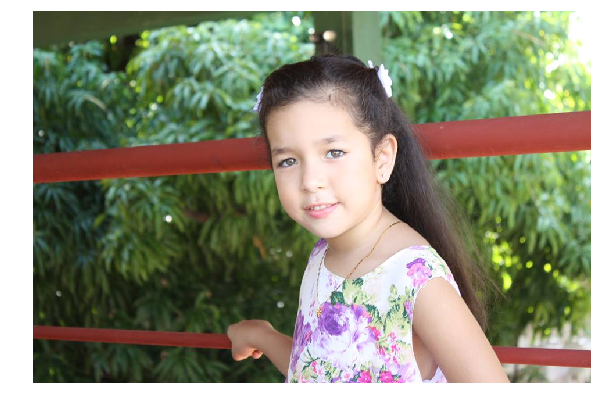

In [49]:
pathnameimage = '../out/image960x640.jpg'
image = cv2.imread(pathnameimage)[:,:,(2,1,0)]
print(image.shape)
imageshow(image)

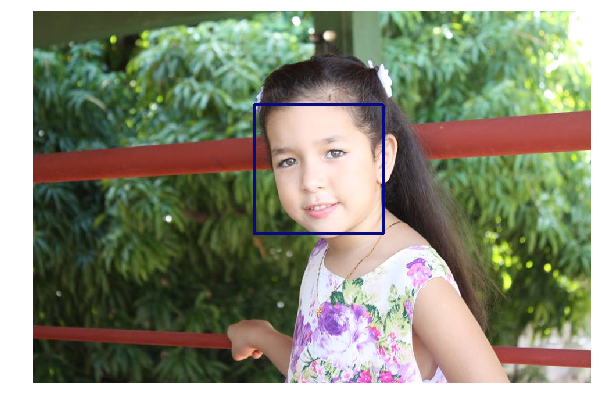

In [11]:
#x,y,w,h
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
imgray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(imgray, 1.3, 5)

image_sh = image.copy()
for box in faces:
    drawface( image_sh, tobbox(box) )
imageshow( image_sh )


(768, 1024, 3)
face:  0
----------------------------
neutral 0.0000
happiness 99.9993
surprise 0.0000
sadness 0.0000
anger 0.0000
disgust 0.0001
fear 0.0006
contempt 0.0000


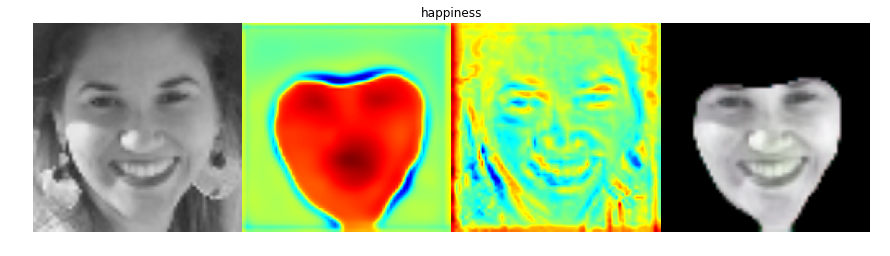

face:  1
----------------------------
neutral 0.0000
happiness 99.9979
surprise 0.0000
sadness 0.0000
anger 0.0020
disgust 0.0001
fear 0.0000
contempt 0.0000


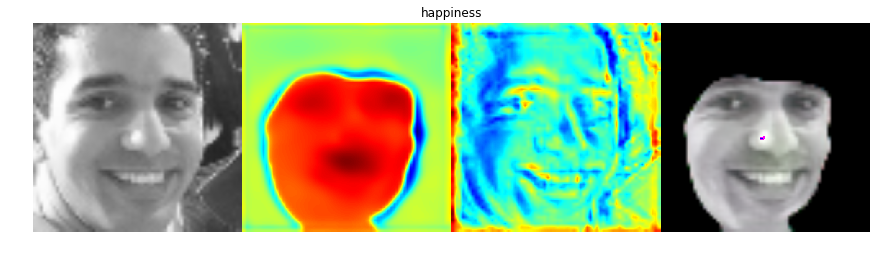

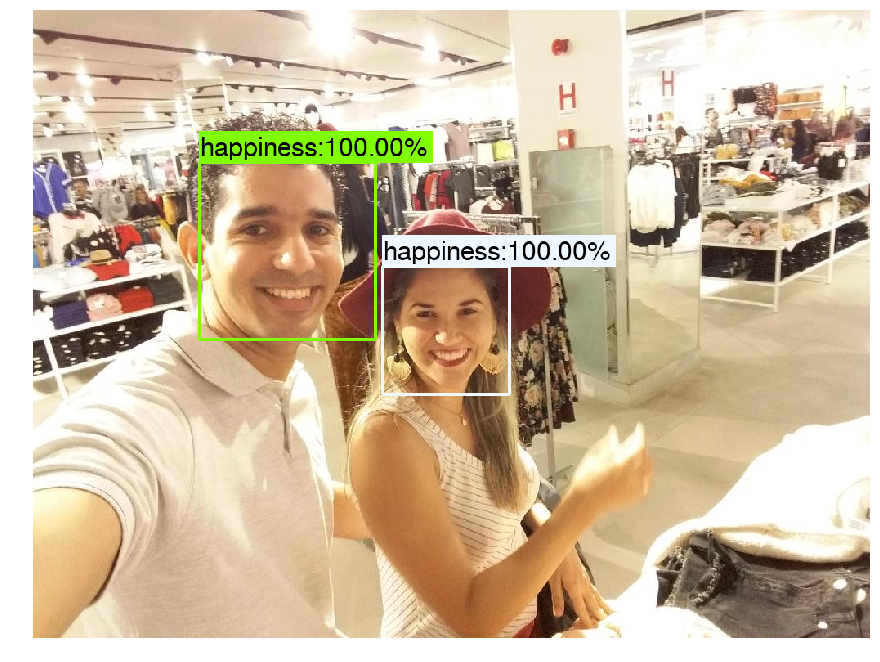

In [33]:
emotion_name = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']

# pathnameimage = '../out/image960x640.jpg'
pathnameimage = '../out/image1024x760.jpg'
# pathnameimage = '../out/tristesa_9.jpg'
# pathnameimage = '../out/motorola-cin.jpg'
# pathnameimage = '../out/img005.jpeg'

image = cv2.imread(pathnameimage)[:,:,(2,1,0)]
# image = crop(image,20)
# image = pad(image,20)
# image = cv2.resize( image, (image.shape[1]//2,image.shape[0]//2) )
print(image.shape)

#x,y,w,h
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# face detection
imgray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(imgray, 1.3, 5)

# classification
frame_proc = cFrame( image_size=[128,128,3] ) 
track   = cTrack( net, image_size=64 )

# emotion recognition
image_sh = image.copy()
for k, box in enumerate(faces):
    
    bbox = tobbox(box)
    imface = roi(image, bbox)
    
    
    #imface = tofer(imface)
    #imfacetensor = torch.from_numpy(imface[:,:,np.newaxis, np.newaxis].transpose((2, 3, 0, 1))).float()
    #imfacetensor = torch.cat((imfacetensor, imfacetensor, imfacetensor), dim=1)
    
    imagesize = 64
    imface = np.stack( (imface,imface,imface), axis=2 )
    imface = cv2.resize( imface, (imagesize, imagesize) )

    # predict 
    att, fmap, srf, yhat, yhat_max = track( imface )
    #att_map = att.mean(axis=2)
    #att = norm(att)
           
    score = dict(zip(emotion_name, yhat[0] ))    
    labelhat = TF.softmax( yhat, dim=1 )[0,:]
    curremot = max(score.items(), key=operator.itemgetter(1)) 
    
    print('face: ', k)
    print('----------------------------')
    for e,v in score.items():
        print(e, '{:.4f}'.format(v*100) )
    
    # draw result
    draw_bounding_box( image_sh, bbox, curremot, color=STANDARD_COLORS[k] )
    #drawface( image_sh, bbox )
    
    
    im_att = showatt( imface, labelhat, att, fmap.mean(axis=2), srf, emotion_name, imsize=500, midsize=250 )
    
    
    plt.figure( figsize=(15,8) )
    plt.imshow( im_att )
    plt.title( emotion_name[  torch.argmax(labelhat) ] )
    plt.axis('off')
    plt.ioff()
    plt.show()


plt.figure( figsize=(15,20) )
plt.imshow(image_sh)
plt.axis('off')
plt.ioff()
plt.show()







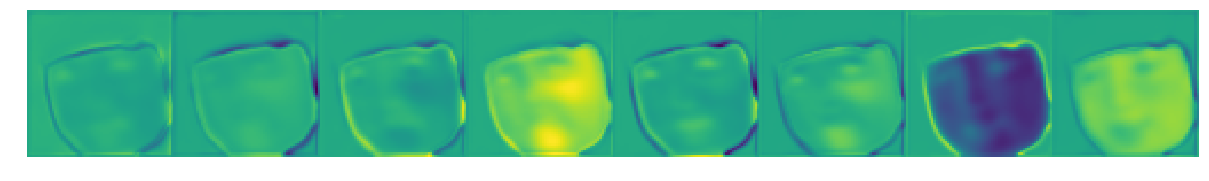

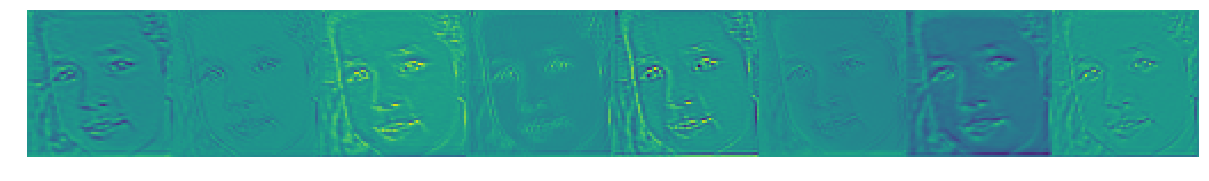

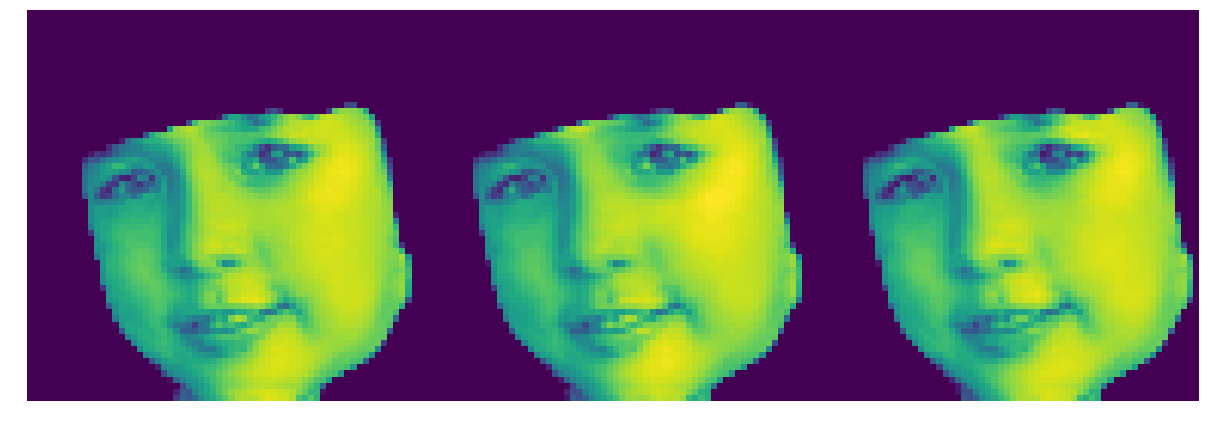

In [19]:

def to_expand( x ):
    x_exp = [ ix  for ix in x.transpose( (2,0,1) )  ]
    x_exp = np.concatenate(x_exp, axis=1 )
    return x_exp

def imshow(im, figsize=(8,8) ):
    plt.figure( figsize=figsize )
    plt.imshow( im )
    plt.axis('off')
    plt.ioff()
    plt.show()

im_fmap = to_expand(fmap)
im_srf  = to_expand(srf)
im_att  = to_expand(att)

# im_err_c1  = att[:,:, 0] - image
# im_err_c2  = att[:,:, 1] - image
# im_err_c3  = att[:,:, 2] - image
# im_err = np.stack( (im_err_c1,im_err_c2,im_err_c3) , axis=1 )

# im_err = (np.abs(att - image)) *(att>0 )
# im_err  = to_expand(im_err)


imshow(im_fmap, figsize=(21,8)  )
imshow(im_srf, figsize=(21,8)  )
imshow( im_att, figsize=(21,8)  )
# imshow( im_err, figsize=(21,8)  )




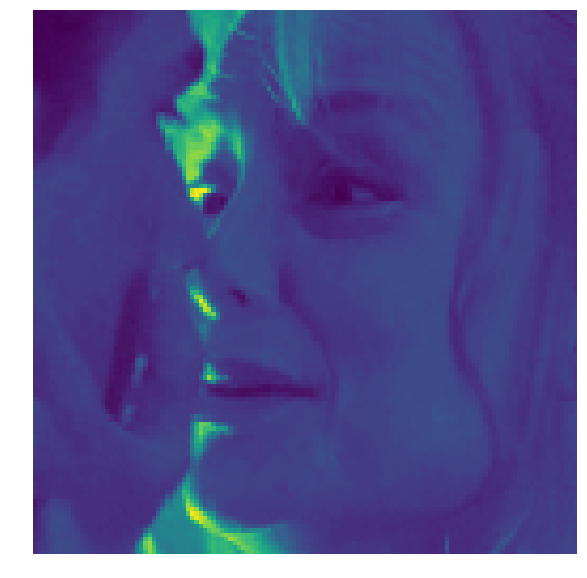

In [40]:
# nt = net.net
# nt

pathnameimage = '../out/ferproblem.png'
imface = cv2.imread(pathnameimage)[:,:,(2,1,0)]
imface = imface.mean(2)
imageshow(imface)


In [10]:
def vistensor(tensor, ch=0, allfeature=False, nrow=8, padding=1, brgb=True, scol=1, srow=1): 
    """
    vistensor: visuzlization tensor
        @ch: visualization channel 
        @allkernels: visualization all tensores
    """        
    n,c,w,h = tensor.shape
    if allfeature: tensor = tensor.view(n*c,-1,w,h )
    elif brgb:
        tensor = tensor[:,ch:(ch+3),:,:]
    else: 
        tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
        
    rows = np.min( (tensor.shape[0]//nrow + 1, 64 )  )    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    
    #print(grid.shape)
    #print(nrow,rows)
    
    plt.figure( figsize=(nrow*scol,rows*srow) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.ioff()
    plt.show()
    

torch.Size([1, 8, 64, 64])


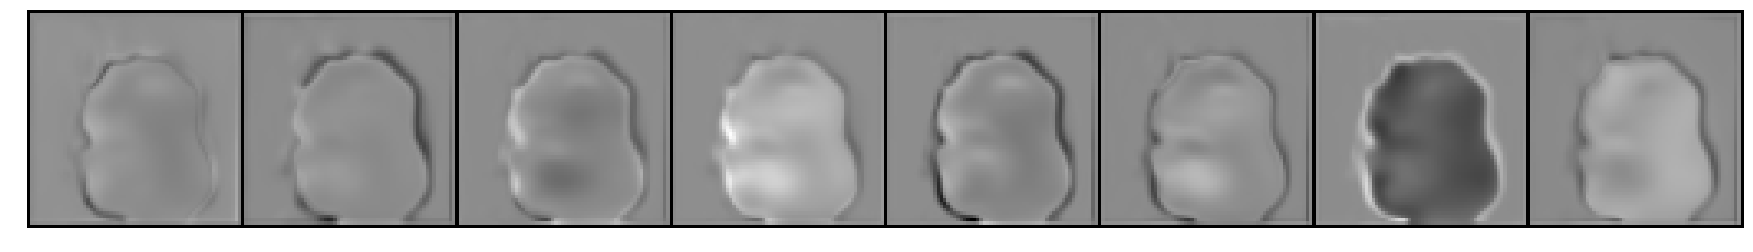

In [41]:
nt = net.net

x = imface
# x = x.mean(axis=2)        
x = np.stack( (x,x,x), axis=2 )
x = cv2.resize( x, (64,64) )
x = torch.from_numpy(x).permute( (2,0,1) ).unsqueeze(0).float().cuda()
x = x/255.0

nt.eval()
lg_att = nt.attention_map( x )

print(lg_att.shape)
vistensor( lg_att.cpu().detach(), nrow=8 , allfeature=True, brgb=False, scol=25, srow=2 )



torch.Size([1, 8, 64, 64])


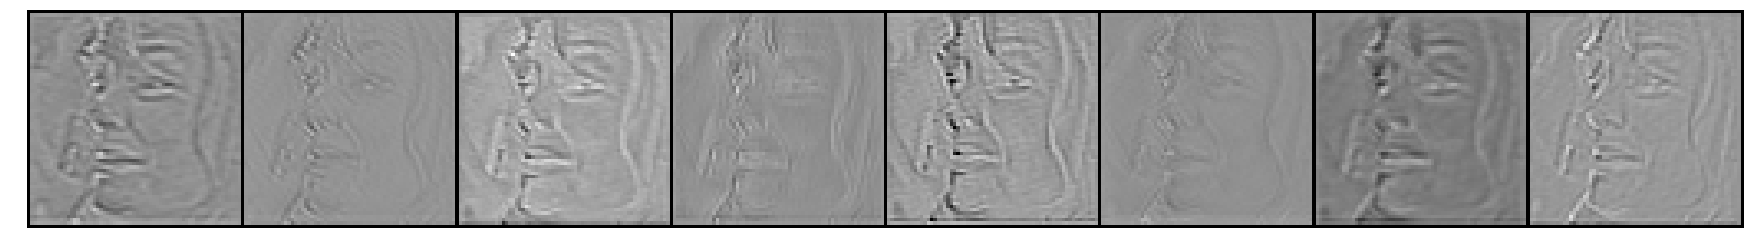

In [42]:

#feature module
out = nt.conv_input( x )
residual = out
out = nt.feature( out )
out = nt.conv_mid(out)
lg_ft = torch.add(out, residual )

print(lg_ft.shape)
vistensor( lg_ft.cpu().detach(), nrow=8 , allfeature=True, brgb=False, scol=25, srow=2 )
       

torch.mul( TF.sigmoid( lg_att ) ,  lg_ft ) 
torch.Size([1, 8, 64, 64])


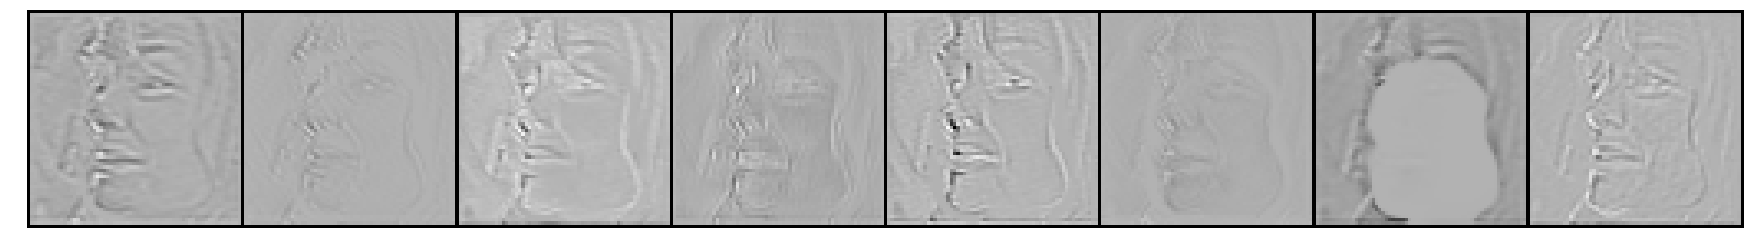

nt.reconstruction( torch.cat( (lattmap, x, lg_att) , dim=1 ) ) 
torch.Size([1, 3, 64, 64])


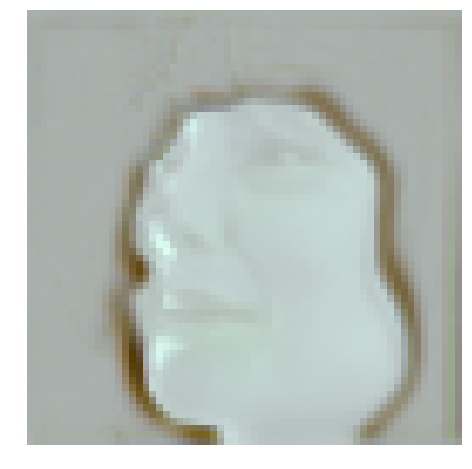

latt_norm = nt.conv2_bn(latt)
torch.Size([1, 3, 64, 64])


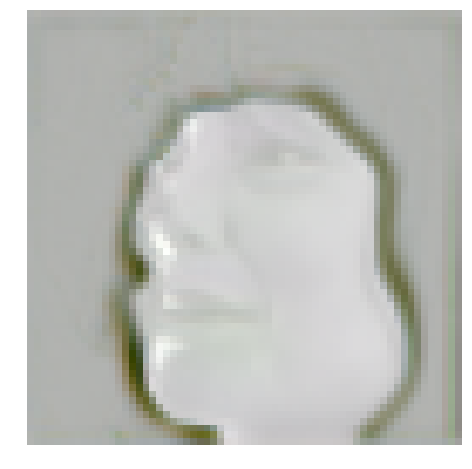

TF.relu(latt_norm)
torch.Size([1, 3, 64, 64])


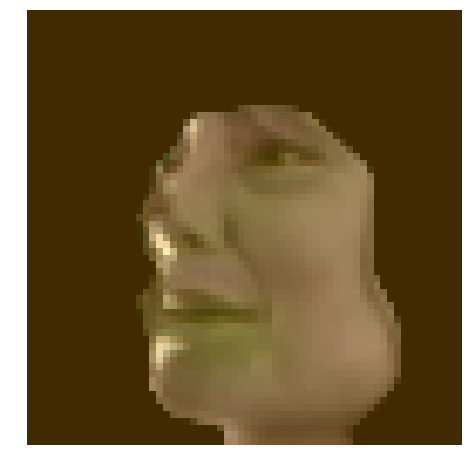

F.avg_pool2d(latt_relu, 2)
torch.Size([1, 3, 32, 32])


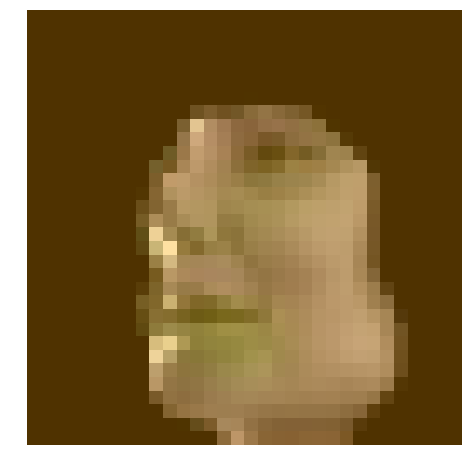

In [43]:
from torch.nn import functional as TF

def normalize_layer(x):
    x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
    x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
    x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
    x = torch.cat((x_ch0, x_ch1, x_ch2), 1)
    return x


#fusion
lattmap = torch.mul( TF.sigmoid( lg_att ),  lg_ft )   
latt = nt.reconstruction( torch.cat( (lattmap, x, lg_att) , dim=1 ) )   
latt_norm = nt.conv2_bn(latt)
latt_relu = normalize_layer(TF.relu(latt_norm)) #normalize_layer
latt_pool = TF.avg_pool2d(latt_relu, 2)


# print( (latt_relu.permute(2,3,1,0 )[:,:,:,0].cpu().detach().numpy() - att).sum()  )


print('torch.mul( TF.sigmoid( lg_att ) ,  lg_ft ) ')
print(lattmap.shape)
vistensor( lattmap.cpu().detach(), nrow=8 , allfeature=True, brgb=False, scol=25, srow=2 )

print('nt.reconstruction( torch.cat( (lattmap, x, lg_att) , dim=1 ) ) ')
print(latt.shape)
vistensor( latt.cpu().detach(), nrow=3 , allfeature=False, brgb=True, scol=8, srow=8 )

print('latt_norm = nt.conv2_bn(latt)')
print(latt_norm.shape)
vistensor( latt_norm.cpu().detach(), nrow=3 , allfeature=False, brgb=True, scol=8, srow=8 )

print('TF.relu(latt_norm)')
print(latt_relu.shape)
vistensor( latt_relu.cpu().detach(), nrow=3 , allfeature=False, brgb=True, scol=8, srow=8)

print('F.avg_pool2d(latt_relu, 2)')
print(latt_pool.shape)
vistensor( latt_pool.cpu().detach(), nrow=3 , allfeature=False, brgb=True, scol=8, srow=8 )



ntc.conv1(latt_pool)
torch.Size([1, 64, 32, 32])


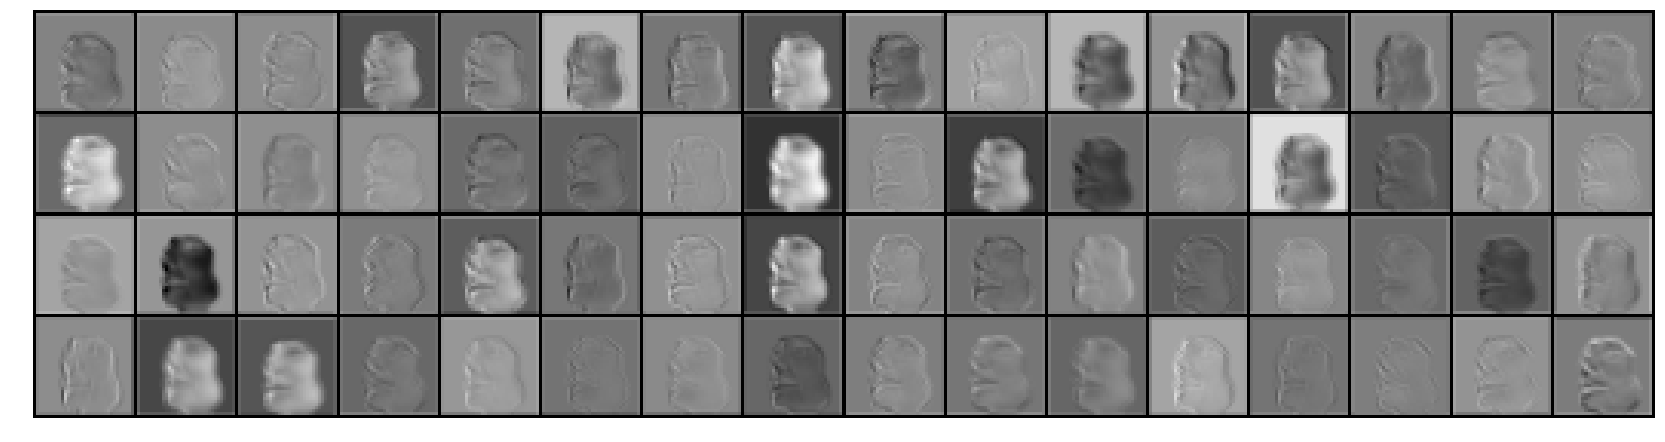

ntc.layer1(out1)
torch.Size([1, 64, 32, 32])


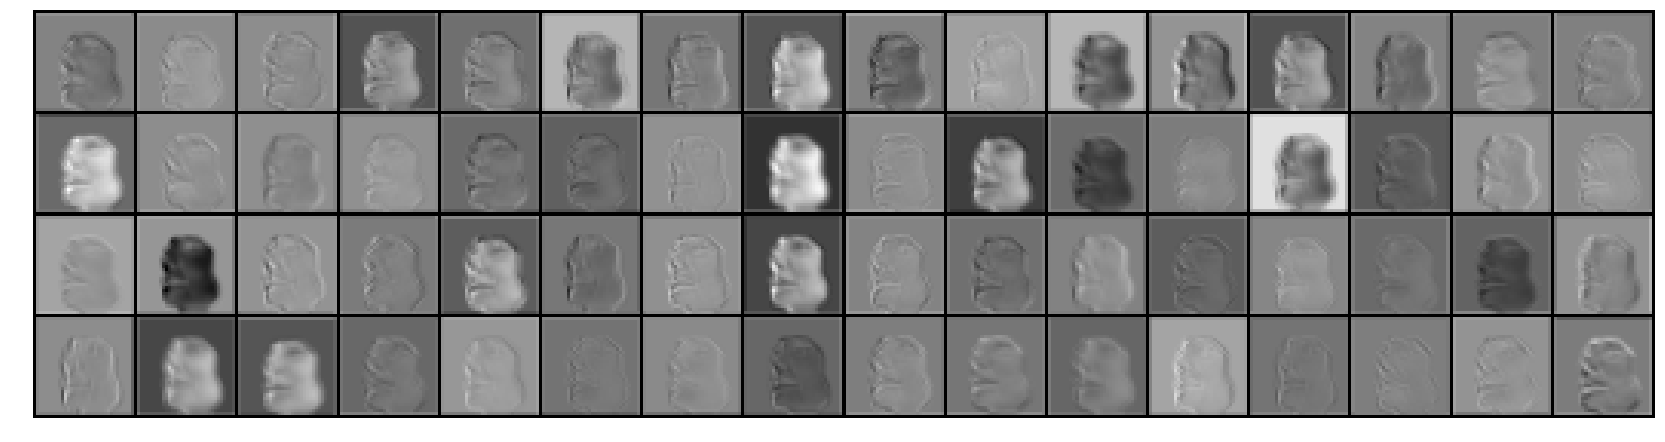

In [44]:

ntc = nt.netclass

out1 = ntc.conv1(latt_pool)
out2 = ntc.layer1(out1)
out3 = ntc.layer2(out2)
out4 = ntc.layer3(out3)
out5 = ntc.layer4(out4)

print('ntc.conv1(latt_pool)')
print(out1.shape)
vistensor( out1.cpu().detach(), nrow=16 , allfeature=True, brgb=False, scol=3, srow=1.5 )

print('ntc.layer1(out1)')
print(out2.shape)
vistensor( out2.cpu().detach(), nrow=16 , allfeature=True, brgb=False, scol=3, srow=1.5 )



ntc.layer1(out2)
torch.Size([1, 128, 16, 16])


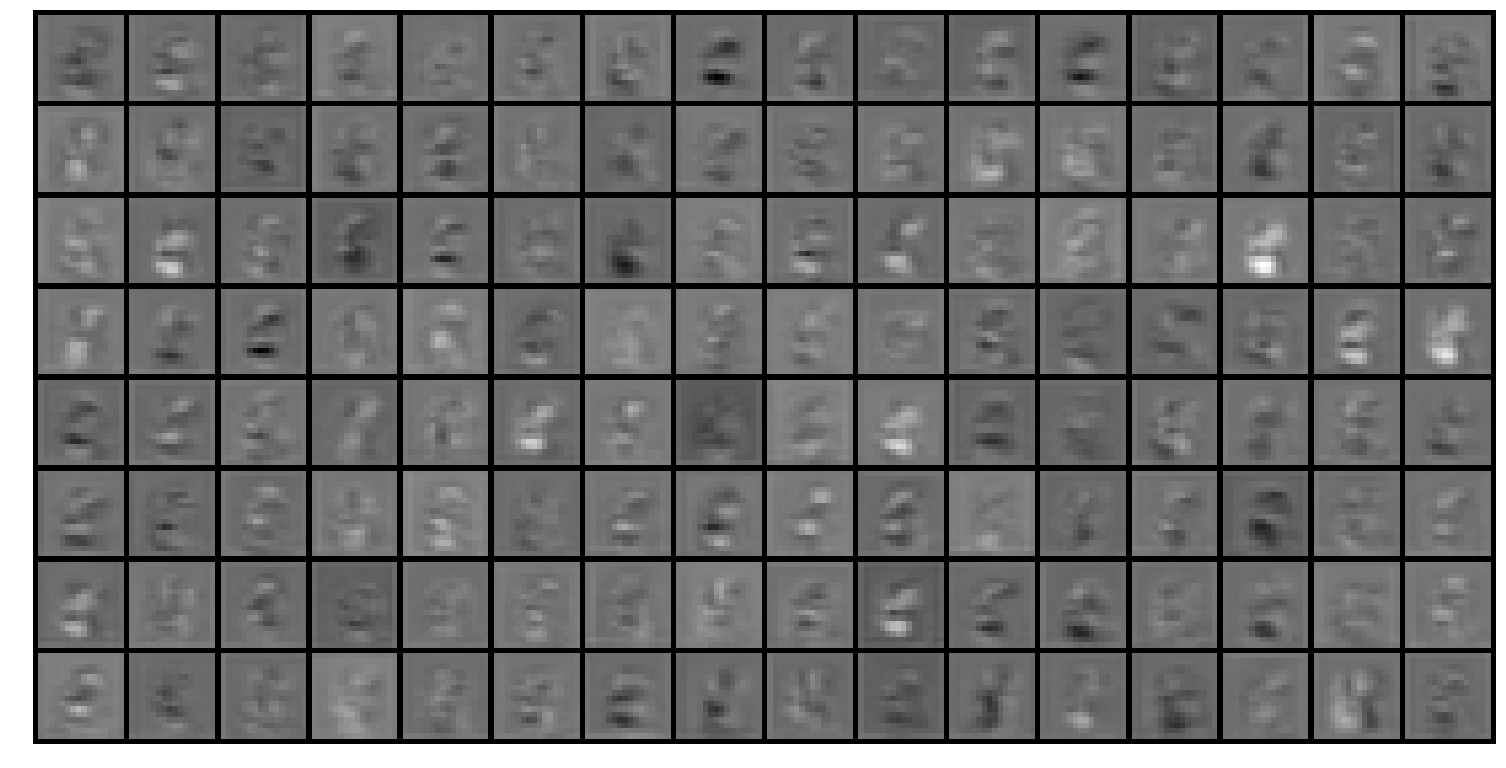

In [45]:
print('ntc.layer1(out2)')
print(out3.shape)
vistensor( out3.cpu().detach(), nrow=16 , allfeature=True, brgb=False, scol=3, srow=1.5 )

ntc.layer1(out3)
torch.Size([1, 256, 8, 8])


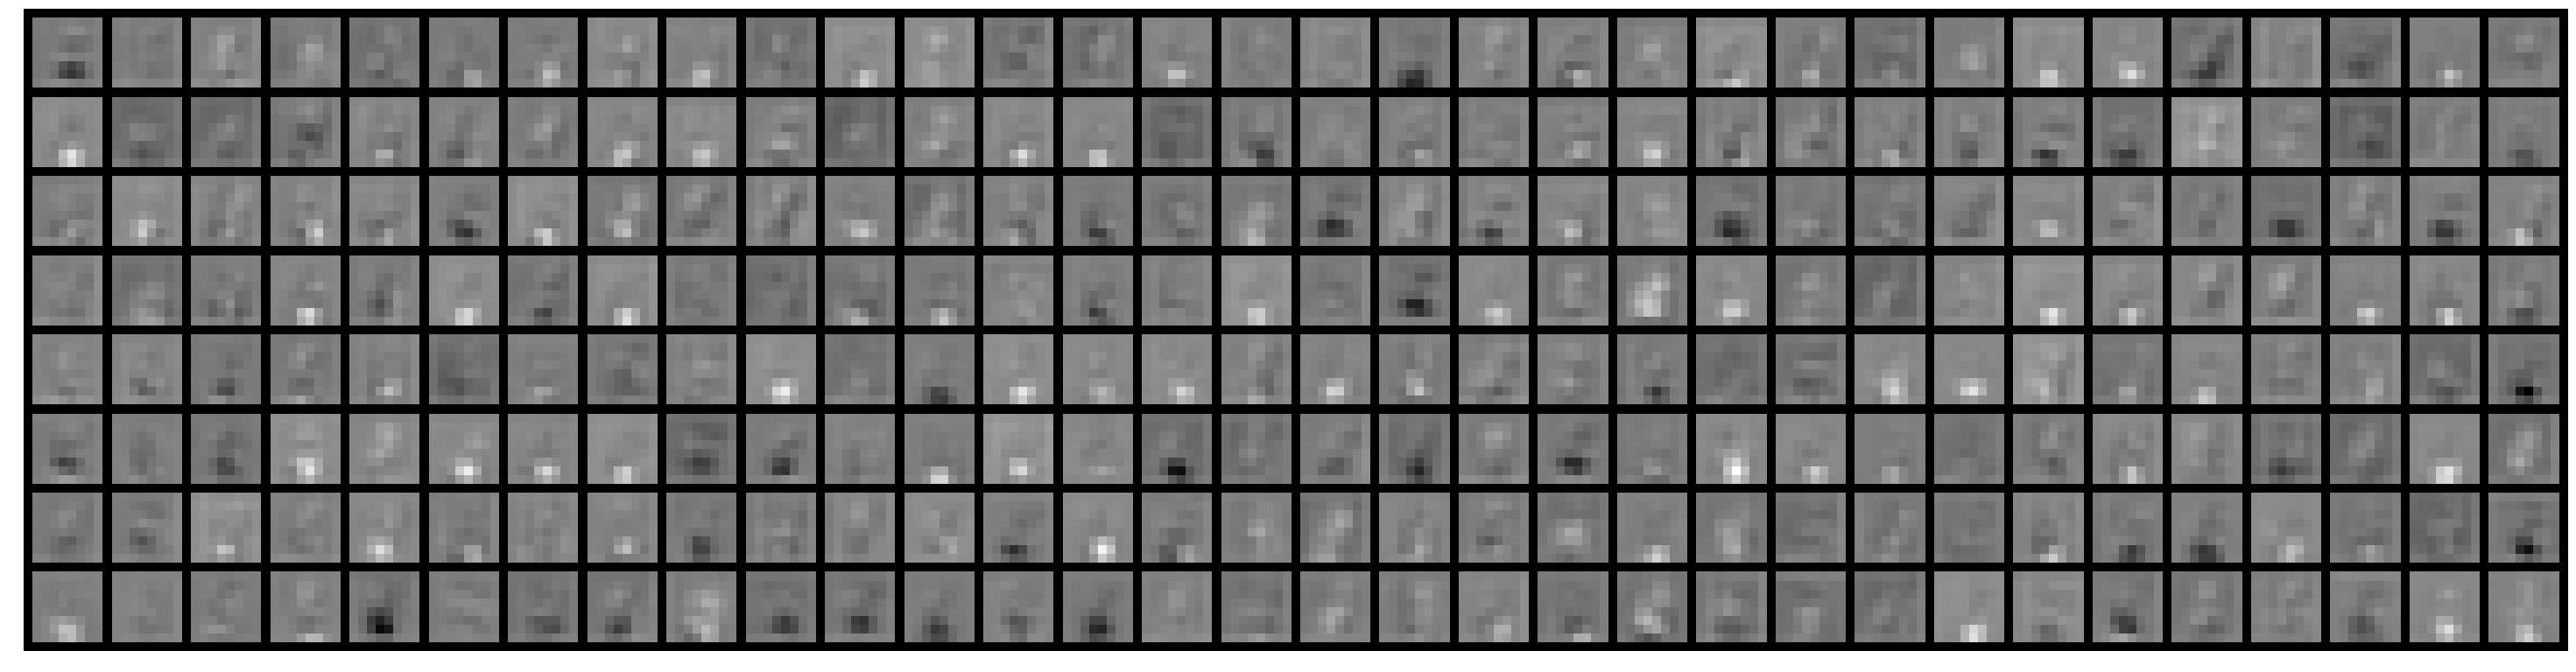

In [16]:
print('ntc.layer1(out3)')
print(out4.shape)
vistensor( out4.cpu().detach(), nrow=32 , allfeature=True, brgb=False, scol=2, srow=1.5 )

ntc.layer1(out4)
torch.Size([1, 512, 4, 4])


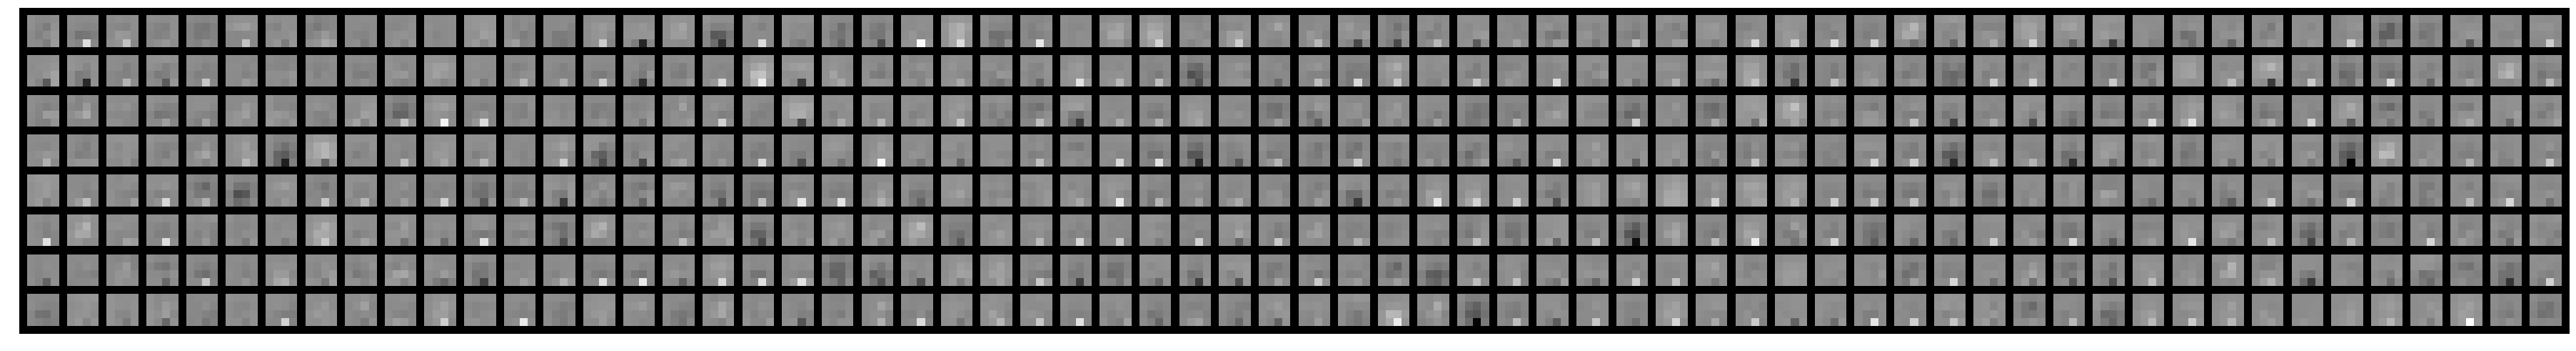

In [17]:
print('ntc.layer1(out4)')
print(out5.shape)
vistensor( out5.cpu().detach(), nrow=64 , allfeature=True, brgb=False, scol=1, srow=1 )

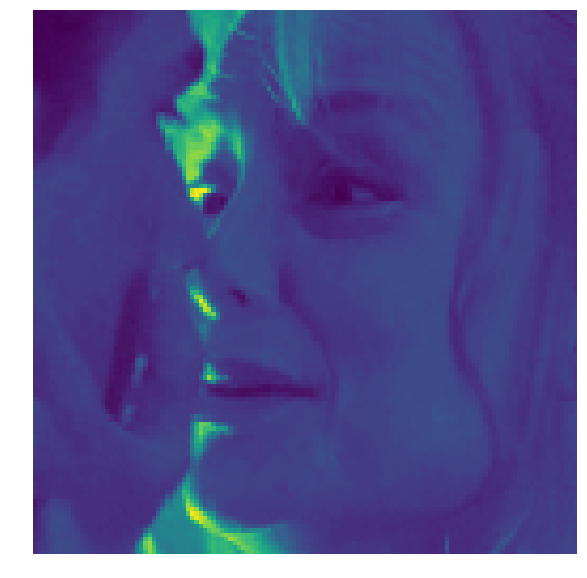

In [34]:
pathnameimage = '../out/ferproblem.png'
imface = cv2.imread(pathnameimage)[:,:,(2,1,0)]
imface = imface.mean(2)
imageshow(imface)

In [39]:

nt = net.net

x = imface
# x = x.mean(axis=2)        
x = np.stack( (x,x,x), axis=2 )
x = cv2.resize( x, (64,64) )
x = torch.from_numpy(x).permute( (2,0,1) ).unsqueeze(0).float().cuda()
x = x/255.0

print(x.shape)

nt.eval()
yhat, att, fmap, srf = nt( x )
print(yhat)

labelhat = TF.softmax( yhat, dim=1 )[0,:]
score = dict(zip(emotion_name, labelhat ))   
curremot = max(score.items(), key=operator.itemgetter(1)) 

print(labelhat)
print(curremot)

print('face: ')
print('----------------------------')
for e,v in score.items():
    print(e, '{:.4f}'.format(v*100) )



torch.Size([1, 3, 64, 64])
tensor([[ 0.5633,  2.4507, -1.0294,  2.1263, -1.6439, -1.2328, -1.4901,  2.0098]],
       device='cuda:1', grad_fn=<AddmmBackward>)
tensor([0.0580, 0.3832, 0.0118, 0.2770, 0.0064, 0.0096, 0.0074, 0.2465],
       device='cuda:1', grad_fn=<SliceBackward>)
('happiness', tensor(0.3832, device='cuda:1', grad_fn=<SelectBackward>))
face: 
----------------------------
neutral 5.8034
happiness 38.3164
surprise 1.1803
sadness 27.6996
anger 0.6384
disgust 0.9630
fear 0.7446
contempt 24.6544
